# Luenberger's Investment Wheel

In [3]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_mosek()

pyomo was previously installed
mosek was previously installed


## Problem statement

David Luenberger presents an "investment wheel" in Chapter 18 of his book *Investment Science*. The wheel is divided into sectors, each marked with a number. An investor places wagers on one or more sectors before spinning the wheel.  When the wheel stops, the investor receives a payout equal to the wager times the number appearing next to the marker. The wagers on all other sectors are lost. The game is repeated indefinitely.

![](investment-wheel.png)

Given an initial wealth $W_0$, what is your investing strategy for repeated plays of the game?

* Is there an investing strategy that almost surely grows? 
* What is the mean return for each spin of the wheel?

In [2]:
# specify the investment wheel
wheel = {
    "A": {"p": 1/2, "b": 3},
    "B": {"p": 1/3, "b": 2},
    "C": {"p": 1/6, "b": 6},
}

## Simulation

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import bisect

import ipywidgets as widgets

def wheel_sim(w, T,  N):
    
    keys = list(wheel.keys())
    b = {s: sectors[s]["b"] for s in keys}
    p = {s: sectors[s]["p"] for s in keys}
    q = np.cumsum(list(p.values()))
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))  
    colors = {s: ax.semilogy(0, 1, '.', ms=10)[0].get_color() for s in keys}

    sum_logR = 0
    N_logR = 0
    
    # repeat the simulation N times
    for j in range(N):
        wealth = 1.0
        for k in range(T):
            
            # spin the wheel
            spin = np.random.uniform()
            sector = keys[bisect.bisect_left(q, spin)
                         ]
            # compute the return
            R = 1 + w[sector] * b[sector] - sum(w[s] for s in sectors)
            
            ax.semilogy([k, k+1], [wealth, wealth *R], c=colors[sector], alpha=0.4)
            ax.semilogy(k+1, wealth * R, '.', ms=4, c=colors[sector], alpha=0.4)
            wealth = wealth * R
            
            sum_logR += np.log(R)
            N_logR += 1

    ax.set_xlim(0, T)
    ax.set_ylim(0.01, 1000.0)
    
    ElogR = sum_logR/N_logR
    ax.plot(np.exp(ElogR*np.linspace(0, T, T+1)), lw=5, alpha=0.5)
    ax.set_title(f"E[log(R)] = {ElogR:0.5f}")
    ax.set_ylabel("Wealth")
    ax.set_xlabel("Stages")
    ax.grid(True)
    
@widgets.interact
def wheel_interact1(wA=(0.0, 1.0, 0.01), wB=(0.0, 1.0, 0.01), wC=(0.0, 1.0, 0.01)):
    w = {"A": wA, "B": wB, "C": wC}
    wheel_sim(w, 40, 20)


interactive(children=(FloatSlider(value=0.5, description='wA', max=1.0, step=0.01), FloatSlider(value=0.5, des…

## Modeling

The investment wheel is an example of a game with $n=3$ outcomes. For each outcome $n$ there is a payout $b_n$ that occurs with probability $p_n$ as shown in the following table.

| Outcome | Probability $p_n$ | Odds $b_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 3 |
| B | 1/3 | 2 |
| C | 1/6 | 6 |

If a fraction of wealth $w_n$ is wagered on each outcome $n$, then the gross returns are given in the following table.

| Outcome | Probability $p_n$ | Gross Returns $R_n$ |
| :--: | :--: | :--: |
| A | 1/2 | 1 + 2$w_A$ - $w_B$ - $w_C$ |
| B | 1/3 | 1 - $w_A$ + $w_B$ - $w_C$ |
| C | 1/6 | 1 - $w_A$ - $w_B$ + 5$w_C$ |

For a general game with $n$ outcomes,the optimization problem is to maximize expected log return 

$$
\begin{align}
\max_{w \geq 0}\quad & \sum_{n\in N} p_n \log(R_n) \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
\end{align}
$$


Reformulation of the objective function with exponential cones gives a conic program.

$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
\end{align}
$$

The solution of this program is shown below.

In [7]:
import pyomo.kernel as pmo

def wheel(sectors):

    m = pmo.block()
    
    S = sectors.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in S})
    
    # objective
    m.ElogR = pmo.objective(sum(sectors[s]["p"]*m.q[s] for s in S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + sectors[s]["b"]*m.w[s] - sum(m.w[s] for s in S)) for s in S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in S})

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m
        
m = wheel(sectors)

print(f"Expected Gross Return = {np.exp(m.ElogR()): 0.5f}\n")
for s in sectors.keys():
    print(f"Sector {s}:  p = {sectors[s]['p']:0.4f}   b = {sectors[s]['b']:0.2f}   w = {m.w[s]():0.5f}")

Expected Gross Return =  1.06991

Sector A:  p = 0.5000   b = 3.00   w = 0.42322
Sector B:  p = 0.3333   b = 2.00   w = 0.21814
Sector C:  p = 0.1667   b = 6.00   w = 0.12826


## Adding risk aversion

For the risk constrained case, we consider a constraint

$$\mathbb{E}[R^{-\lambda}] \leq 1$$

where $\lambda$ is a risk aversion parameter.

$$\sum_{n\in N} p_n R_n^{-\lambda} \leq 1$$

Again

$$\sum_{n\in N} e^{\log(p_1) - \lambda\log(R_1)} \leq 1$$

Introducing $u_n \geq e^{\log(p_n) - \lambda q_n}$ using the $q_n$ defined above, we get

$$
\begin{align}
\sum_{n\in N} u_n & \leq 1 \\
(u_n, 1, \log(p_n) - \lambda q_n) & \in K_{exp} & \forall n\in N \\
\end{align}
$$

The risk-constrained investment wheel is now


$$
\begin{align}
\max_{w\geq 0}\quad & \sum_{n\in N} p_n q_n \\
\text{s.t.}\quad \\
& \sum_{n\in N} w_n \leq 1 \\
&\sum_{n\in N} u_n  \leq 1 \\
& R_n = 1 + b_n w_n - \sum_{n\in N} w_n & \forall n\in N \\
& (R_n, 1, q_n) \in K_{exp} & \forall n \in N \\
& (u_n, 1, \log(p_n) - \lambda q_n) \in K_{exp} & \forall n\in N \\
\end{align}
$$


In [20]:
import pyomo.kernel as pmo

def wheel_rc(sectors, lambd=0):

    m = pmo.block()
    
    S = sectors.keys()

    # decision variables
    m.w = pmo.variable_dict({s: pmo.variable(lb=0) for s in S})
    m.q = pmo.variable_dict({s: pmo.variable() for s in S})
    
    # objective
    m.ElogR = pmo.objective(sum(sectors[s]["p"]*m.q[s] for s in S), sense=pmo.maximize)
    
    # expression for returns
    m.R = pmo.expression_dict({s: pmo.expression(1 + sectors[s]["b"]*m.w[s] - sum(m.w[s] for s in S)) for s in S})
    
    # constraints
    m.sum_w = pmo.constraint(sum(m.w[s] for s in S) <= 1)
    m.conic = pmo.block_dict({s: pmo.conic.primal_exponential.as_domain(m.R[s], 1, m.q[s]) for s in S})
    
    # risk constraints
    m.u = pmo.variable_dict({s: pmo.variable() for s in S})
    m.sum_u = pmo.constraint(sum(m.u[s] for s in S) <= 1)
    m.risk =  pmo.block_dict(
        {s: pmo.conic.primal_exponential.as_domain(m.u[s], 1, np.log(sectors[s]["p"]) - lambd*m.q[s]) for s in S}
    )

    # solve with 'mosek_direct' (conic) or 'ipopt' (nonlinear)
    pmo.SolverFactory('mosek_direct').solve(m)

    return m
        
m = wheel_rc(sectors, 0)

print(f"Expected Gross Return = {np.exp(m.ElogR()): 0.5f}\n")
for s in sectors.keys():
    print(f"Sector {s}:  p = {sectors[s]['p']:0.4f}   b = {sectors[s]['b']:0.2f}   w = {m.w[s]():0.5f}")
    

Expected Gross Return =  1.06991

Sector A:  p = 0.5000   b = 3.00   w = 0.42324
Sector B:  p = 0.3333   b = 2.00   w = 0.21818
Sector C:  p = 0.1667   b = 6.00   w = 0.12829


In [21]:
@widgets.interact
def wheel_interact2(lambd=(0, 10, 1)):
    m = wheel_rc(sectors, lambd)
    w = {s: m.w[s]() for s in sectors.keys()}
    wheel_sim(w, 40, 20)


interactive(children=(IntSlider(value=5, description='lambd', max=10), Output()), _dom_classes=('widget-intera…

## How does risk aversion change the solution?

The following cell demonstrates the effect of increasing the risk aversion parameter $\lambda$.

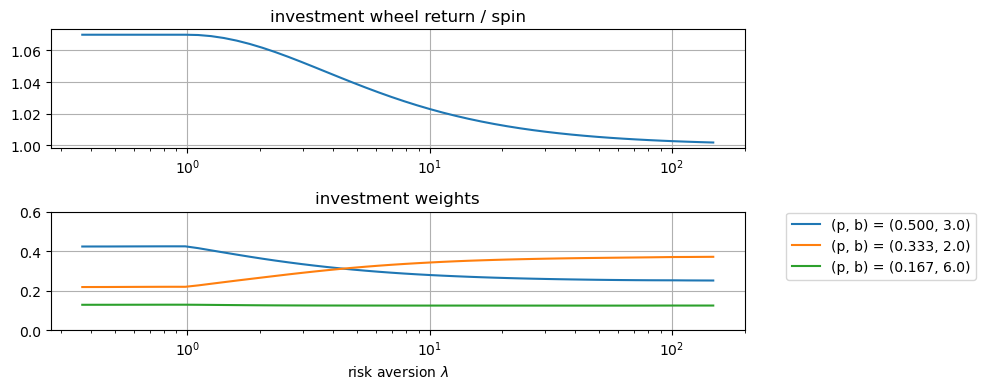

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(10, 4))

v = np.linspace(-1, 5)
lambd = np.exp(v)
results = [wheel_rsk(sectors, _) for _ in lambd]

ax[0].semilogx(lambd, [np.exp(m.ElogR()) for m in results])
ax[0].set_title('investment wheel return / spin')
ax[0].grid(True)

ax[1].semilogx(lambd, [[m.w[s]() for s in sectors.keys()] for m in results])
ax[1].set_title('investment weights')
ax[1].set_xlabel('risk aversion $\lambda$')
ax[1].legend([f"(p, b) = ({sectors[s]['p']:0.3f}, {sectors[s]['b']:0.1f})" for s in sectors.keys()],
            bbox_to_anchor=(1.05, 1.05))
ax[1].grid(True)
ax[1].set_ylim(0, 0.6)

fig.tight_layout()

## Exercises

1. Is there a deterministic investment strategy for the investment wheel?. That is, is there investment strategy that provides a fixed return regardless of the outcome of the spin? Set up and solve a model to find that strategy.

2. Find the variance in the outcome of the wheel, and plot the variance as a function of the risk aversion parameter $\lambda$. What is the relationship of variance and $\lambda$ in the limit as $\lambda \rightarrow 0$? See the paper by Busseti, E., Ryu, E. K., & Boyd, S. (2016) for ideas on how to perform this analysis.

## Bibliographic Notes

The Kelly Criterion has been included in many tutorial introductions to finance and probability, and the subject of popular accounts.

> Poundstone, W. (2010). Fortune's formula: The untold story of the scientific betting system that beat the casinos and Wall Street. Hill and Wang. https://www.onlinecasinoground.nl/wp-content/uploads/2020/10/Fortunes-Formula-boek-van-William-Poundstone-oa-Kelly-Criterion.pdf

> Thorp, E. O. (2017). A man for all markets: From Las Vegas to wall street, how i beat the dealer and the market. Random House.

> Thorp, E. O. (2008). The Kelly criterion in blackjack sports betting, and the stock market. In Handbook of asset and liability management (pp. 385-428). North-Holland. https://www.palmislandtraders.com/econ136/thorpe_kelly_crit.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2010). Good and bad properties of the Kelly criterion. Risk, 20(2), 1.  https://www.stat.berkeley.edu/~aldous/157/Papers/Good_Bad_Kelly.pdf

> MacLean, L. C., Thorp, E. O., & Ziemba, W. T. (2011). The Kelly capital growth investment criterion: Theory and practice (Vol. 3). world scientific. https://www.worldscientific.com/worldscibooks/10.1142/7598#t=aboutBook

>  https://en.wikipedia.org/wiki/Kelly_criterion

Luenberger's investment wheel is 

> Luenberger, D. (2009). Investment science: International edition. OUP Catalogue.  https://global.oup.com/ushe/product/investment-science-9780199740086


The utility of conic programming to solve problems involving log growth is more recent. Here are some representative papers.

> Cajas, D. (2021). Kelly Portfolio Optimization: A Disciplined Convex Programming Framework. Available at SSRN 3833617. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3833617

> Busseti, E., Ryu, E. K., & Boyd, S. (2016). Risk-constrained Kelly gambling. The Journal of Investing, 25(3), 118-134. https://arxiv.org/pdf/1603.06183.pdf


> Fu, A., Narasimhan, B., & Boyd, S. (2017). CVXR: An R package for disciplined convex optimization. arXiv preprint arXiv:1711.07582. https://arxiv.org/abs/1711.07582

> Sun, Q., & Boyd, S. (2018). Distributional robust Kelly gambling. arXiv preprint arXiv: 1812.10371. https://web.stanford.edu/~boyd/papers/pdf/robust_kelly.pdf

The recent work by CH Hsieh extends these concepts in important ways for real-world implementation.

> Hsieh, C. H. (2022). On Solving Robust Log-Optimal Portfolio: A Supporting Hyperplane Approximation Approach. arXiv preprint arXiv:2202.03858. https://arxiv.org/pdf/2202.03858
